In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
# Cell 2: Load and inspect data
train_df = pd.read_csv('data/sign_mnist_train.csv')
test_df = pd.read_csv('data/sign_mnist_test.csv')
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Sample labels:", train_df['label'].head())

Training data shape: (27455, 785)
Test data shape: (7172, 785)
Sample labels: 0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64


In [4]:
# Temporary Cell: Inspect labels
print("Unique labels in y_train:", np.unique(train_df['label']))
print("Unique labels in y_test:", np.unique(test_df['label']))

Unique labels in y_train: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Unique labels in y_test: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [5]:
# Cell 3: Prepare features and labels
import numpy as np
from tensorflow.keras.utils import to_categorical

# Filter valid labels (0-23)
valid_labels = np.arange(24)  # [0, 1, ..., 23]
train_df = train_df[train_df['label'].isin(valid_labels)]
test_df = test_df[test_df['label'].isin(valid_labels)]

# Extract features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Normalize and reshape for CNN (28x28x1 images)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels (24 classes, A-Y, skipping J=9, Z=25)
y_train = to_categorical(y_train, 24)
y_test = to_categorical(y_test, 24)

# Verify shapes and labels
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Unique labels in y_train after filtering:", np.unique(np.argmax(y_train, axis=1)))
print("Unique labels in y_test after filtering:", np.unique(np.argmax(y_test, axis=1)))

X_train shape: (26337, 28, 28, 1)
y_train shape: (26337, 24)
X_test shape: (6840, 28, 28, 1)
y_test shape: (6840, 24)
Unique labels in y_train after filtering: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique labels in y_test after filtering: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [6]:
# Cell 4: Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(24, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\akhil\asl_sign_language_project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,840 (886.09 KB)

 Trainable params: 226,840 (886.09 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cell 5: Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 277s 61ms/step - accuracy: 0.3299 - loss: 2.1962 - val_accuracy: 0.8673 - val_loss: 0.4718
Epoch 2/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.8443 - loss: 0.4600 - val_accuracy: 0.9115 - val_loss: 0.3032
Epoch 3/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.9197 - loss: 0.2269 - val_accuracy: 0.9164 - val_loss: 0.2909
Epoch 4/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.9530 - loss: 0.1392 - val_accuracy: 0.9459 - val_loss: 0.1897
Epoch 5/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.9628 - loss: 0.1082 - val_accuracy: 0.9466 - val_loss: 0.1975
Epoch 6/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - accuracy: 0.9699 - loss: 0.0874 - val_accuracy: 0.9461 - val_loss: 0.2080
Epoch 7/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9729 - loss: 0.0770 - val_accuracy: 0.9393 - val_loss: 0.2293
Epoch 8/10
824/824 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9801 - loss: 0.0567 -

In [8]:
# Cell 6: Save model
model.save('asl_model.h5')

In [9]:
# Cell 7: Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9466 - loss: 0.2916
Test accuracy: 0.9453


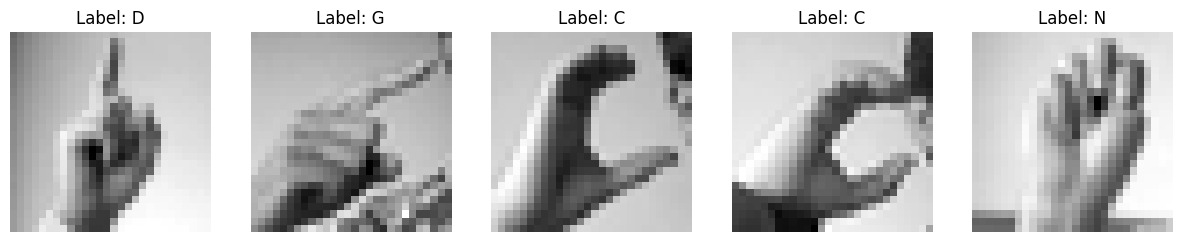

In [13]:
# Cell 8: Visualize sample images
import matplotlib.pyplot as plt

# Plot first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    img = X_train[i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {chr(np.argmax(y_train[i]) + 65)}')
    ax.axis('off')
plt.show()

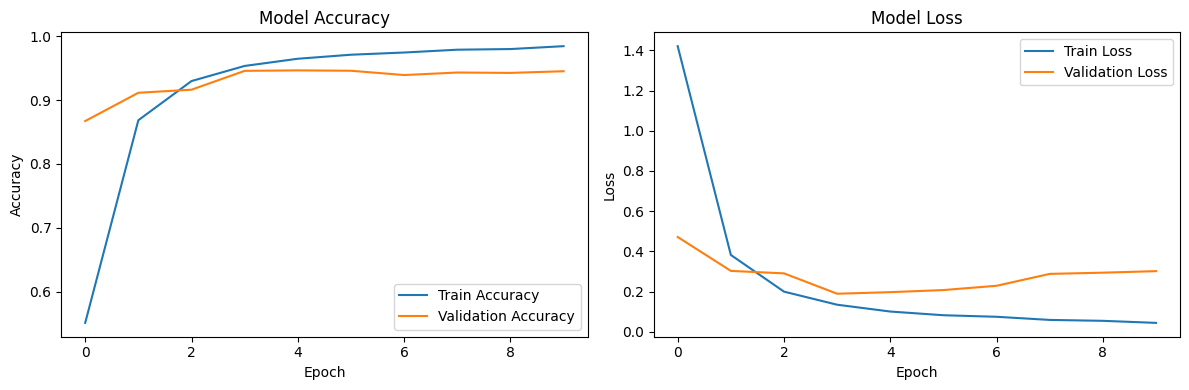

In [14]:
# Cell 9: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()